In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import requests
import yfinance as yf

In [116]:
#------------------
'''Define API key'''
api_key = '17b993e3-1e66-445c-989b-7b6f6f12c046'
#------------------

#------------------
'''use API to get current price'''
def get_current_btc_price(api_key):
    #  https://pro.coinmarketcap.com/account
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest'
    parameters = {
        'symbol': 'BTC',
        'convert': 'USD'
    }
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key,
    }
    response = requests.get(url, headers=headers, params=parameters)
    data = response.json()
    btc_price = data['data']['BTC']['quote']['USD']['price']
    return btc_price
#------------------

#------------------
'''compute relative strength index'''
def compute_rsi(data, window=14):
    delta = data.diff(1).dropna()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

#------------------

#------------------
'''
automate the most up to date historical data
'''
# Define the ticker symbol
tickerSymbol = 'BTC-USD'

# Get the current date
current_date = datetime.now().strftime('%Y-%m-%d')

# Get historical data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# Using the current date as the end date
tickerDf = tickerData.history(period='1d', start='2014-9-17', end=current_date)

# Reset the index to turn the date index into a column
tickerDf.reset_index(inplace=True)

# Save to CSV
tickerDf.to_csv('BTC-USD.csv', index=False)
#------------------

#------------------
'''Data conversion logic'''

# Load the data from the CSV file
historical_data = pd.read_csv('BTC-USD.csv')

# Convert 'Date' column to datetime and set as index
historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%Y-%m-%d %H:%M:%S%z')
historical_data.set_index('Date', inplace=True)

# Convert 'Price' to numeric
historical_data['Close'] = historical_data['Close'].astype(str)  # Convert to string
historical_data['Price'] = pd.to_numeric(historical_data['Close'].str.replace(',', ''), errors='coerce')

# Convert 'Vol.' to numeric (assuming 'K' stands for thousand)
historical_data['Volume'] = historical_data['Volume'].astype(str)  # Convert to string
historical_data['Volume'] = pd.to_numeric(historical_data['Volume'].str.replace(',', ''), errors='coerce') * 1000

# Calculate RSI and Moving Average
historical_data['RSI'] = compute_rsi(historical_data['Price'])
historical_data['Moving_Average'] = historical_data['Price'].rolling(window=50).mean()

# Drop rows with NaN values created by rolling function
historical_data.dropna(inplace=True)

# If historical_data is empty, raise an informative error
if historical_data.empty:
    raise ValueError('No data available after processing. Check data conversions and dropna operations.')

# Define a target variable for machine learning
historical_data['Future_Price'] = historical_data['Price'].shift(-1)
historical_data.dropna(inplace=True)
#------------------

#------------------
'''machine learning logic'''
# Split data into features and target for machine learning
X = historical_data[['Price', 'Volume', 'Moving_Average', 'RSI']]
y = historical_data['Future_Price']

# Check if X or y are empty
if X.empty or y.empty:
    raise ValueError('Features (X) or target (y) are empty after processing. Check data integrity and target variable creation.')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Model training
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Model prediction
predictions = model.predict(X_test)

# Evaluate model (implement an evaluation metric)
print("Model Accuracy: ", model.score(X_test, y_test))
#------------------


Model Accuracy:  0.9973521988109761


In [117]:

#------------------
'''to sell or not to sell'''
def should_sell(current_price, historical_data, threshold=0.70):
    # Calculate additional technical indicators
    ath_price = historical_data['Price'].max()
    rsi = historical_data['RSI'].iloc[-1]  # Latest RSI value
    moving_average_50 = historical_data['Price'].rolling(window=50).mean().iloc[-1]
    moving_average_200 = historical_data['Price'].rolling(window=200).mean().iloc[-1]

    # Sentiment Analysis (assuming sentiment_score is a function you have defined or integrated)
    # sentiment = sentiment_score()  # Implement this based on your sentiment analysis module

    # Adaptive Threshold
    if rsi > 70:  # Overbought condition
        threshold -= 0.05
    elif rsi < 30:  # Oversold condition
        threshold += 0.05

    # Adjust threshold based on moving averages
    if current_price > moving_average_50 > moving_average_200:
        threshold -= 0.03  # Strong bullish trend
    elif current_price < moving_average_50 < moving_average_200:
        threshold += 0.03  # Bearish trend

    # Incorporate sentiment analysis
    # if sentiment < -0.5:  # Highly negative market sentiment
    #     threshold += 0.05

    # Decision Logic
    return current_price < ath_price * (1 - threshold)

# Example usage
current_price = get_current_btc_price(api_key)
ath_price = historical_data['Price'].max()

if should_sell(current_price, historical_data):
    print("It's time to sell")
else:
    print("Hold")
# ------------------

Hold


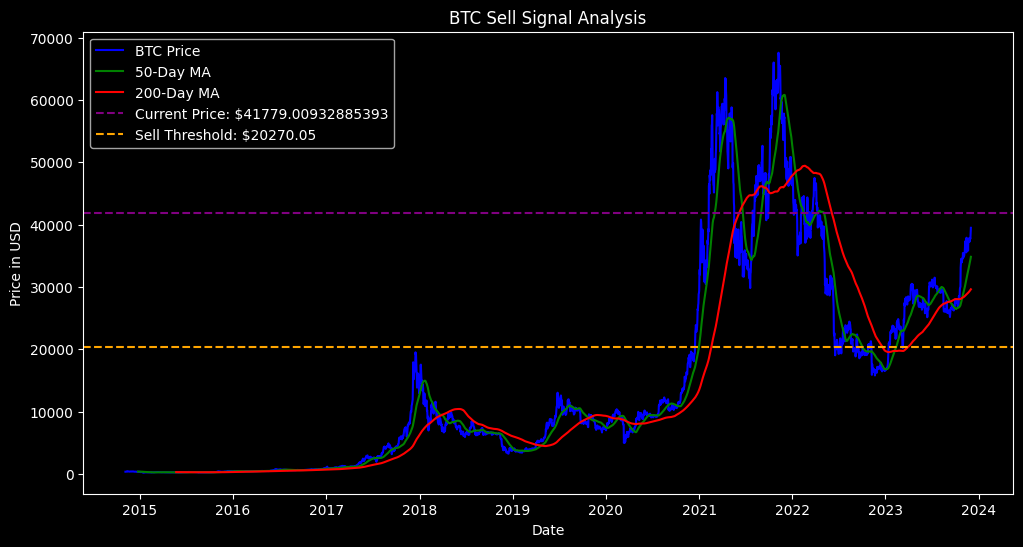

In [118]:
def plot_sell_signal(historical_data, current_price, threshold=0.70):
    ath_price = historical_data['Price'].max()
    sell_threshold_price = ath_price * (1 - threshold)

    # Calculate moving averages for plotting
    ma_50 = historical_data['Price'].rolling(window=50).mean()
    ma_200 = historical_data['Price'].rolling(window=200).mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title("BTC Sell Signal Analysis")
    plt.xlabel("Date")
    plt.ylabel("Price in USD")

    # Plot price and moving averages
    plt.plot(historical_data.index, historical_data['Price'], label='BTC Price', color='blue')
    plt.plot(historical_data.index, ma_50, label='50-Day MA', color='green')
    plt.plot(historical_data.index, ma_200, label='200-Day MA', color='red')

    # Highlight current price and sell threshold
    plt.axhline(y=current_price, color='purple', linestyle='--', label=f'Current Price: ${current_price}')
    plt.axhline(y=sell_threshold_price, color='orange', linestyle='--', label=f'Sell Threshold: ${sell_threshold_price:.2f}')

    # Improve formatting
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    # plt.gcf().autofmt_xdate()  # Rotation

    plt.legend()
    plt.show()

# Example usage
current_price = get_current_btc_price(api_key)
plot_sell_signal(historical_data, current_price)


In [119]:
# Assuming historical_data is a DataFrame with your BTC price data
ath_price = historical_data['Price'].max()  # Current ATH based on historical data

def check_new_ath(current_price, historical_data):
    global ath_price
    new_ath_flag = False
    if current_price > ath_price:
        ath_price = current_price
        new_ath_flag = True
    return new_ath_flag

def gradual_sell_strategy(current_price, btc_holdings, min_btc_threshold):
    sell_plan = {
        '2%': 0.10,
        '5%': 0.15,
    }

    if check_new_ath(current_price, historical_data):
        for drop_percentage, sell_fraction in sell_plan.items():
            drop_threshold = ath_price * (1 - float(drop_percentage.strip('%')) / 100)
            if current_price <= drop_threshold:
                sell_amount = btc_holdings * sell_fraction
                btc_holdings -= sell_amount
                print(f"Selling {sell_amount} BTC at {current_price} (drop: {drop_percentage})")
                if btc_holdings < min_btc_threshold:
                    print("Minimum BTC threshold reached, stopping further sales.")
                    break
    return btc_holdings

# Example usage
current_price = get_current_btc_price(api_key)  # Get the latest BTC price
btc_holdings = 1.0  # Example BTC holdings
min_btc_threshold = 0.2  # Minimum BTC holdings you want to retain

btc_holdings_after_sales = gradual_sell_strategy(current_price, btc_holdings, min_btc_threshold)


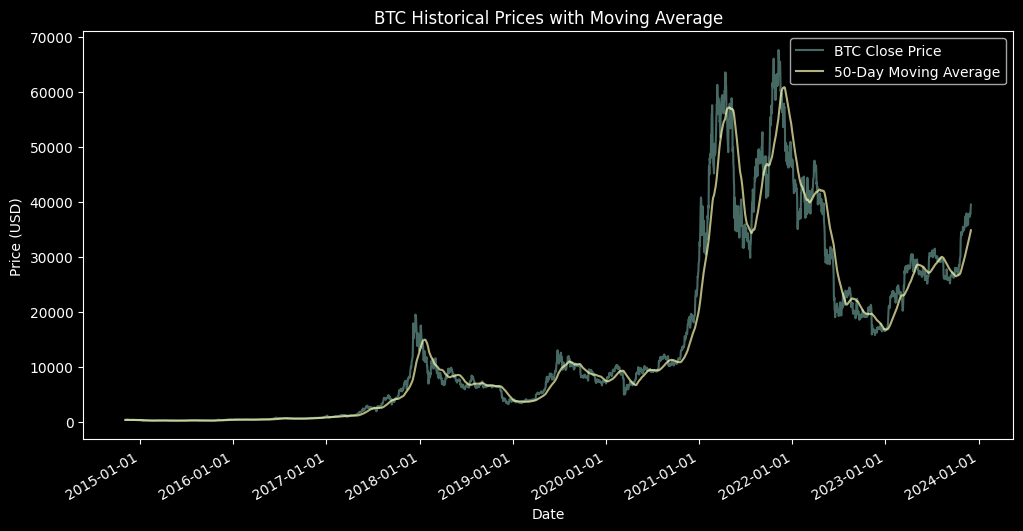

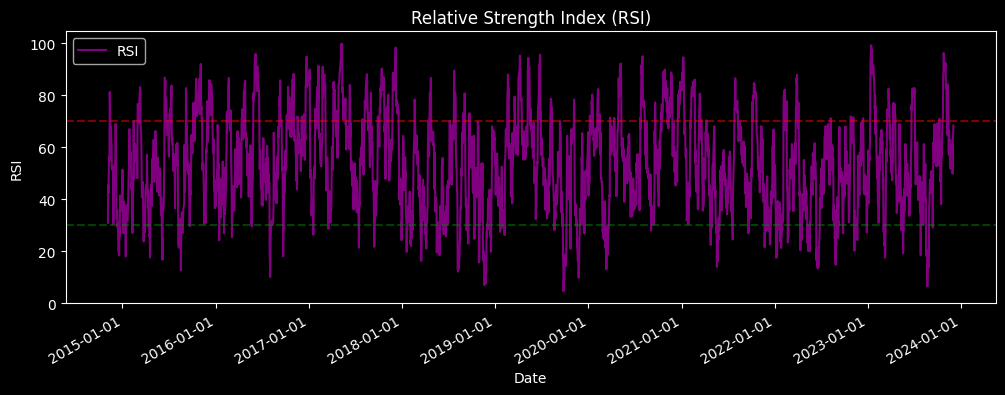

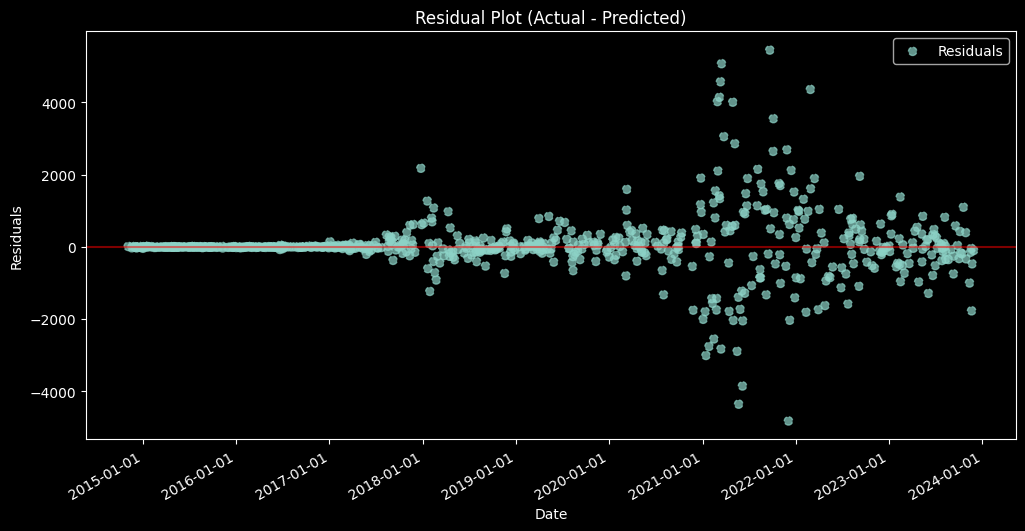

Mean Absolute Error (MAE): 417.99
Mean Squared Error (MSE): 743037.17
Root Mean Squared Error (RMSE): 862.00


In [120]:

# Plotting
plt.style.use('dark_background')

# Plotting Price and Moving Average
plt.figure(figsize=(12, 6))
plt.plot(historical_data.index, historical_data['Price'], label='BTC Close Price', alpha=0.5)
plt.plot(historical_data.index, historical_data['Moving_Average'], label='50-Day Moving Average', alpha=0.7)
plt.title('BTC Historical Prices with Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate dates
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 4))
plt.plot(historical_data.index, historical_data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)  # Overbought line
plt.axhline(30, color='green', linestyle='--', alpha=0.5)  # Oversold line
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Auto-rotate dates
plt.show()

# # Calculate percentage changes
# actual_pct_change = y_test.pct_change()
# predicted_pct_change = pd.Series(predictions).pct_change()

# # Plot percentage changes
# plt.figure(figsize=(12, 6))
# plt.scatter(y_test.index, actual_pct_change, label='Actual % Change', alpha=0.7)
# plt.scatter(y_test.index, predicted_pct_change, label='Predicted % Change', alpha=0.7, linestyle='--')
# plt.title('Model Predictions vs Actual Percentage Changes')
# plt.xlabel('Date')
# plt.ylabel('% Change')
# plt.legend()
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gcf().autofmt_xdate()
# plt.show()

# Calculate residuals
residuals = y_test - predictions

# Plot residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_test.index, residuals, label='Residuals', alpha=0.7, linestyle='--')
plt.axhline(0, color='red', linestyle='-', alpha=0.5)  # Horizontal line at y=0
plt.title('Residual Plot (Actual - Predicted)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")